#### RESNET50 Transfer Learning Implementation on the MNIST-HAM10000 Dataset 
- We will utilize the pre-trained ResNet50 CNN Model in order to carry out diagnosis on the image data exclusively.
- The ResNet50 implementation will yield a more accurate model but will be heavy.

In [1]:
#Import Libraries
import tensorflow as tf 
import keras as K 
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
from scipy import stats
import os

2024-01-21 15:57:32.095614: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-21 15:57:32.127322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 15:57:32.127357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 15:57:32.128146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 15:57:32.133583: I tensorflow/core/platform/cpu_feature_guar

##### Carry out preliminary data analysis
- Plot distribution of categories in metadata.
- Print metadata information.

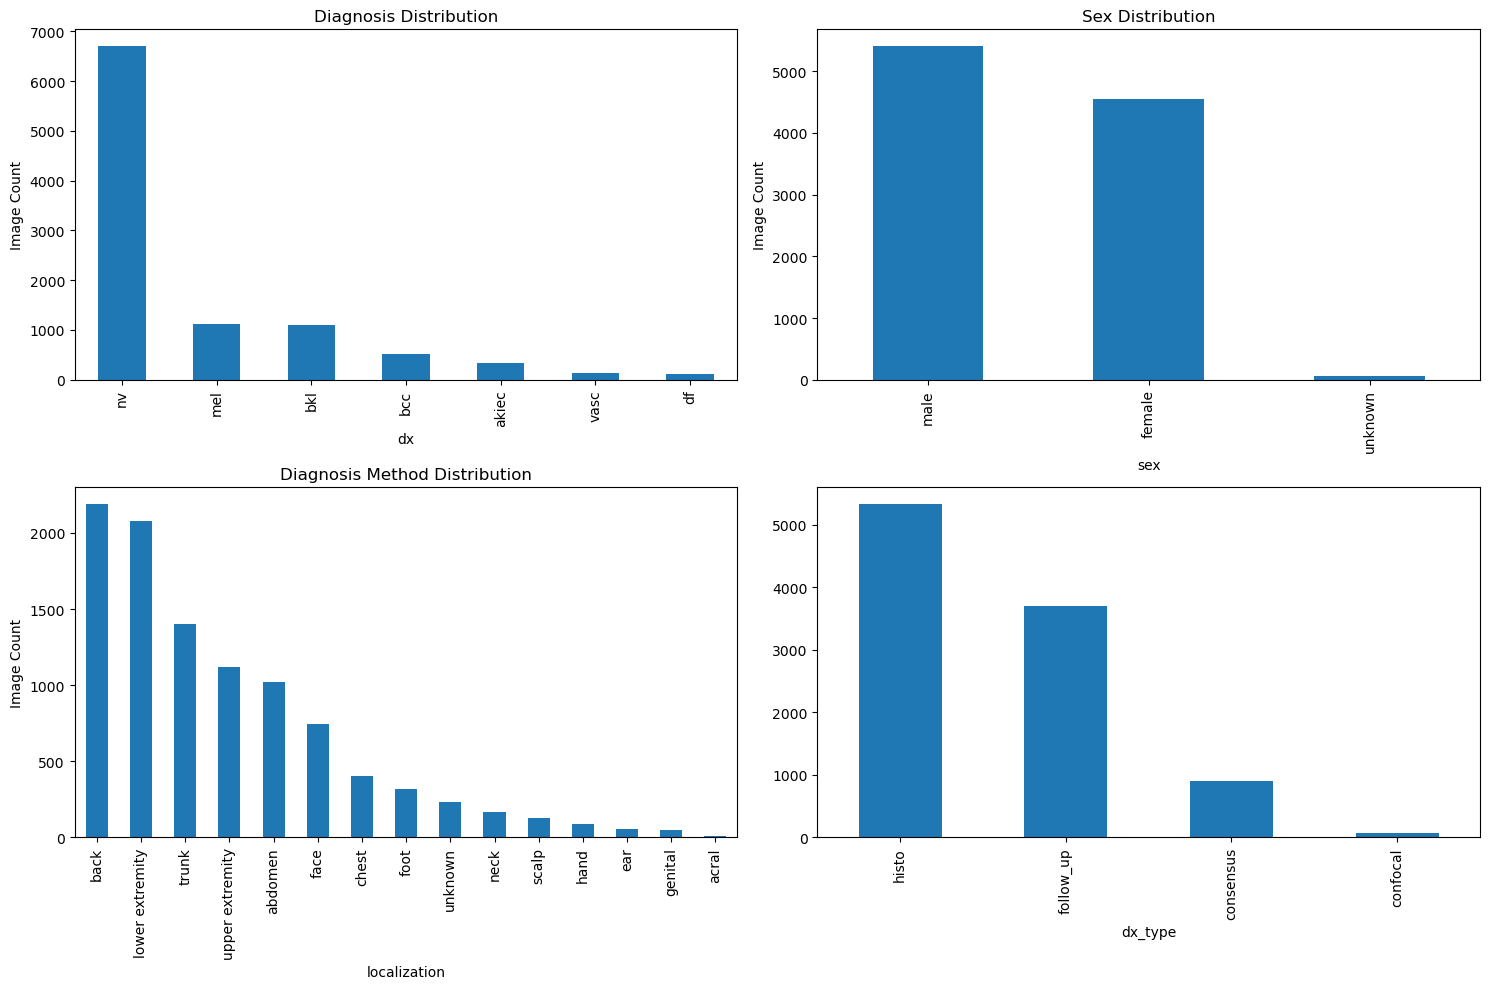

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB
None


In [3]:
meta_data = pd.read_csv('data/HAM10000_metadata.csv')
fig = plt.figure(figsize=(15, 10))

#Diagnosis Distribution
ax1 = fig.add_subplot(221)
meta_data['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Diagnosis Distribution')
ax1.set_ylabel('Image Count')

#Sex Distribution
ax2 = fig.add_subplot(222)
meta_data['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Sex Distribution')
ax2.set_ylabel('Image Count')

#Localization Distribution 
ax3 = fig.add_subplot(223)
meta_data['localization'].value_counts().plot(kind='bar', ax=ax3)
ax3.set_title('Localization Distribution')
ax3.set_ylabel('Image Count')

#Diagnosis Method Distribution 
ax4 = fig.add_subplot(224)
meta_data['dx_type'].value_counts().plot(kind='bar', ax=ax4)
ax3.set_title('Diagnosis Method Distribution')
ax3.set_ylabel('Image Count')

plt.tight_layout()
plt.show()

#Info
print(meta_data.info())

##### Set up Hyper-Parameters

In [2]:
image_width = 224
image_height = 224
batch_size = 32
test_examples = 5021
validation_examples = 5047
train_examples = 32961

##### Initialize Model
- ResNet50 Pretrained

In [35]:
# #Empty Model
# resnet_model = K.models.Sequential()

# #Pretrained Model
# pretrained_model = K.applications.ResNet50(
#     include_top=False, 
#     input_shape=(224, 224, 3), 
#     pooling='avg', 
#     classes=7,
#     weights='imagenet'
# )

# #Set Pretrained Model weights to untrainable
# # for layer in pretrained_model.layers:
# #     layer.trainable = False

# #Amalgamate our final model
# resnet_model.add(pretrained_model)
# resnet_model.add(K.layers.Flatten())
# resnet_model.add(K.layers.Dense(512, activation='relu'))
# resnet_model.add(K.layers.Dense(196, activation='relu'))
# resnet_model.add(K.layers.Dense(7, activation='softmax'))
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
resnet_model = Model(inputs=base_model.input, outputs=x)

In [36]:
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [37]:
resnet_model.save('resnet50_19JAN')

INFO:tensorflow:Assets written to: resnet50_19JAN/assets


INFO:tensorflow:Assets written to: resnet50_19JAN/assets


In [41]:
optimizer = Adam(0.0001)
resnet_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

##### Initialize Data Generators and Data Loaders

In [3]:
#Create Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    zoom_range=(0.95, 0.95),
    horizontal_flip=True,
    vertical_flip=True,
)
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)


In [4]:
#Instantiate Data Generators into loaders
train_gen = train_datagen.flow_from_directory(
    "data/reorganized_train",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
)
test_gen = test_datagen.flow_from_directory(
    "data/reorganized_test",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)
validation_gen = validation_datagen.flow_from_directory(
    "data/reorganized_validation",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

Found 32961 images belonging to 7 classes.
Found 5021 images belonging to 7 classes.
Found 5047 images belonging to 7 classes.


In [5]:
#Load model
resnet_model = K.models.load_model('resnet50_19JAN')

2024-01-21 15:57:55.768208: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-21 15:57:55.793117: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-21 15:57:55.793293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('ResNet_Checkpoints',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

##### Train the Model according to Hyper-Parameters.

In [7]:
history = resnet_model.fit(train_gen,
                    epochs=1, 
                    validation_data = validation_gen,
                    callbacks=callback_list)
resnet_model.save('resnet50_19JAN')

2024-01-21 15:58:24.807033: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-21 15:58:27.576039: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f137a71e730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-21 15:58:27.576059: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2024-01-21 15:58:27.580143: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705832907.649393   29776 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1031/1031 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9986
Epoch 1: val_accuracy improved from -inf to 0.77432, saving model to ResNet_Checkpoints
INFO:tensorflow:Assets written to: ResNet_Checkpoints/assets


INFO:tensorflow:Assets written to: ResNet_Checkpoints/assets


1031/1031 [==============================] - 465s 421ms/step - loss: 0.0097 - accuracy: 0.9986 - val_loss: 1.1932 - val_accuracy: 0.7743 - lr: 1.0000e-05
INFO:tensorflow:Assets written to: resnet50_19JAN/assets


INFO:tensorflow:Assets written to: resnet50_19JAN/assets


In [10]:
resnet_model.evaluate(validation_gen)
resnet_model.evaluate(test_gen)

157/157 [==============================] - 18s 111ms/step - loss: 1.3759 - accuracy: 0.7602


[1.3758876323699951, 0.7602071166038513]

In [11]:
resnet_model.save("Prototyped_Models/resnet-50_standard.h5", save_format='h5')

/home/aarya/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Convert to tflite

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(resnet_model)
tflite_model = converter.convert()
open("Prototyped_Models/converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmproxyxz9q/assets


INFO:tensorflow:Assets written to: /tmp/tmproxyxz9q/assets
2024-01-21 00:57:55.522916: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-21 00:57:55.522948: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-21 00:57:55.523226: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmproxyxz9q
2024-01-21 00:57:55.538937: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-21 00:57:55.538961: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmproxyxz9q
2024-01-21 00:57:55.571496: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-21 00:57:55.591479: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-21 00:57:56.391592: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

96075236

[0. 0. 0. 0. 0. 1. 0.]


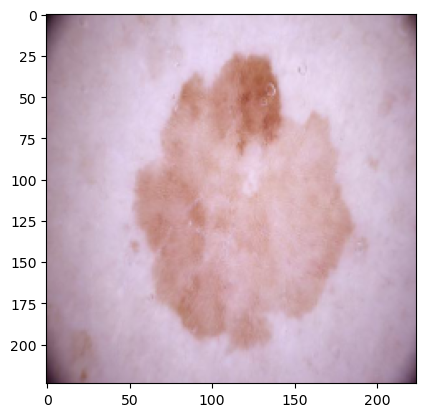

In [30]:
image = train_gen.next()[0][0]
plt.imshow(image)
print(train_gen.next()[1][0])

In [31]:
prediction = tf.round(resnet_model(image.reshape(1, 224, 224, 3)))
print(prediction)

tf.Tensor([[0. 0. 1. 0. 0. 0. 0.]], shape=(1, 7), dtype=float32)
